## Ecommerce Trade Sales

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pytrends.request import TrendReq

from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

#from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')
data.head(2)

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0


In [3]:
# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])
# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})

In [ ]:
retailEcommercesales.head(2)

**Time series plot of Ecommerce trade sales**

In [4]:
retailEcommercesales_ts = retailEcommercesales.set_index('Date')
retailEcommercesales_ts.index = pd.to_datetime(retailEcommercesales_ts.index)

In [ ]:
retailEcommercesales_ts.head(2)

In [5]:
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()
retailEcommercesales_ts = retailEcommercesales_ts.dropna() # removing NA
retailEcommercesales_ts.index = pd.to_datetime(retailEcommercesales_ts[['Growth_rate']].index)
#plt.plot(retailEcommercesales_ts['Growth_rate'])
#plt.show()

In [ ]:
retailEcommercesales_ts.head(2)

In [ ]:
# def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=100, width = 16, height = 5):
#     plt.figure(figsize=(width,height), dpi=dpi)
#     plt.plot(y)
#     plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
#     plt.show()

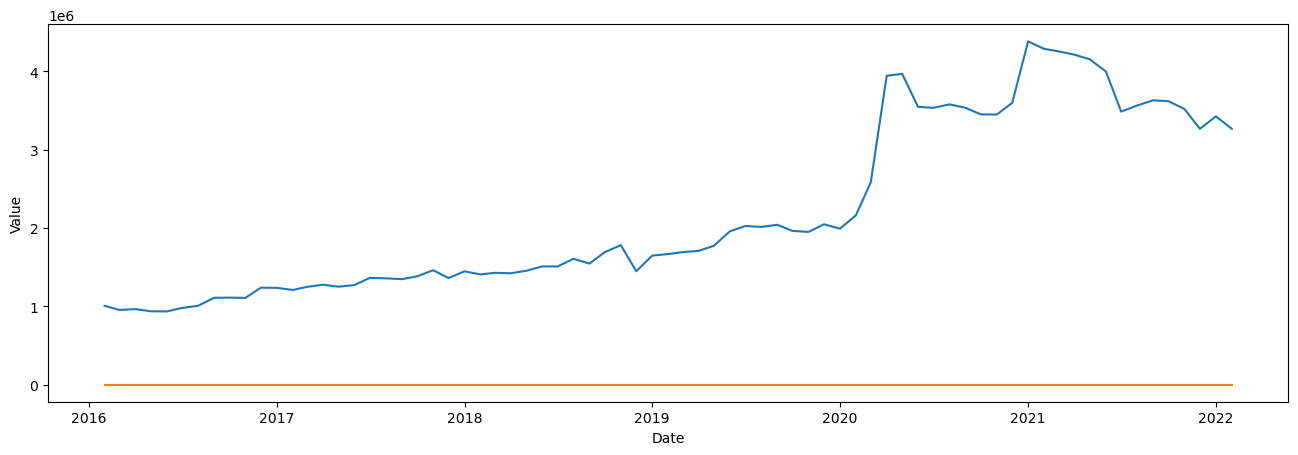

In [6]:
import plots
plots.plots.plot_df(retailEcommercesales_ts)
#plt.show()

In [ ]:
# Plot

plt.plot(retailEcommercesales_ts['Growth_rate'], marker = 'o')

# Labelling
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for E-commerce retail sales")
plt.figure(figsize = (16,5), dpi = 100)

# Display
plt.show()

### Stationarity Statistical test

**KPSS and ADF Test**

**Testing the ecommerce sale\'s series stationarity**

In [7]:
import stationaryTest

stationaryTest.stationarityTest.kpss_test(retailEcommercesales_ts['Growth_rate'])

'Series is stationary'

In [8]:
stationaryTest.check_stationaritytest.check_stationarity(retailEcommercesales_ts)
stationaryTest.stationarityTest.adf_test(retailEcommercesales_ts['Growth_rate'])

Series Ecommerce_sales is not stationary
All other series are stationary


'Series is stationary'

## Keywords extraction using PyTrend

In [ ]:
pytrends = TrendReq(hl = 'en-us', backoff_factor = 0.1)

def ecommerce_trend(keywords = [''],category = '340'):  #subcat - 280
    
    """ 
    Function for getting trends for selected keywords
        
        arguments: 
        
            Keywords: List of String ser
            category: String: stores the code for category
        
        returns: Related queries and related topics from google trend as a data frame
    """
    kw_list = keywords
    cat = category
    timeframe = '2004-01-01 2022-05-11'
    geo = 'CA'
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop = '')
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    
    return data, queries, topics

In [ ]:
data2, queries2, topics2 = ecommerce_trend(keywords = ['Doordash'],category = '340')

In [ ]:
data2.tail()

**Extracting time series from manually extracted keywords**

In [ ]:
keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic

keywords_csv = pd.read_csv('../../data/keywords_data/EECOMMERCE.csv')

In [ ]:
for index, row in keywords_csv.iterrows():
    data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
    
    if index==0:
        FinalData, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        FinalData.rename(columns = {'':str(row['Keyword'])}, inplace = True)    #column name for frame
        FinalData=FinalData.drop(columns=['isPartial'])   #remove column
    else:
        data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        data.rename(columns = {'':str(row['Keyword'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['Keyword'])]
        FinalData = FinalData.join(data)

In [ ]:
#keywords exported as CSV with revelant time series
FinalData.to_csv('EEcommerceKeywordTimeSeries.csv')

**Extracting Queries and related topics time series**

In [ ]:
category_ts, queries, topics = ecommerce_trend(keywords = [''],category = '340')  #function calling

keyword_query_frame = dict()  #Dictionary for queries
keyword_topic_frame = dict()  #Dictionary for topic

# keywords from queries
keyword_rising_query = queries['']['rising']['query'].unique().tolist() 
keyword_top_query = queries['']['top']['query'].unique().tolist()

# keywords from topic
keyword_rising_topics = topics['']['rising']['topic_title'].unique().tolist() 
keyword_top_topics = topics['']['top']['topic_title'].unique().tolist()

In [ ]:
# keywords dict
keyword_query_frame['340'] = keyword_top_query
keyword_topic_frame['340'] = keyword_top_topics

In [ ]:
# keywords from google trend query and topics
keyword_topic_frame

## Evaluating Category\'s time series

In [ ]:
category_ts = category_ts.drop(columns = 'isPartial')
category_ts['Growth_rate'] = category_ts.pct_change()
category_ts = category_ts.dropna()

In [ ]:
# Plot
plt.plot(category_ts['Growth_rate'], marker = 'o')

# Labelling 
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for category:'E-commerce'")
plt.figure(figsize = (16,5), dpi = 100)

# Display
plt.show()

**Category time series stationarity testing**

In [ ]:
stationaryTest.stationarityTest.kpss_test(category_ts['Growth_rate'])

In [ ]:
stationaryTest.check_stationaritytest.check_stationarity(category_ts)

In [ ]:
stationaryTest.stationarityTest.adf_test(category_ts['Growth_rate'])

### Wrangling manually extracted Keywords in EcommerceKeywordTimeSeries.csv

In [9]:
ecommerce_keyword_ts = pd.read_csv('EEcommerceKeywordTimeSeries.csv')
ecommerce_keyword_ts.rename(columns = {'date':'Date'}, inplace = True)
ecommerce_keyword_ts = ecommerce_keyword_ts.set_index(['Date'])
ecommerce_keyword_ts.index = pd.to_datetime(ecommerce_keyword_ts.index)
ecommerce_keyword_ts = ecommerce_keyword_ts.dropna()

In [10]:
ecommerce_keyword_ts.head(2)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,60,0,...,0,0,54,40,0,0,80,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,12,0,...,0,0,48,44,46,0,0,0,0,0


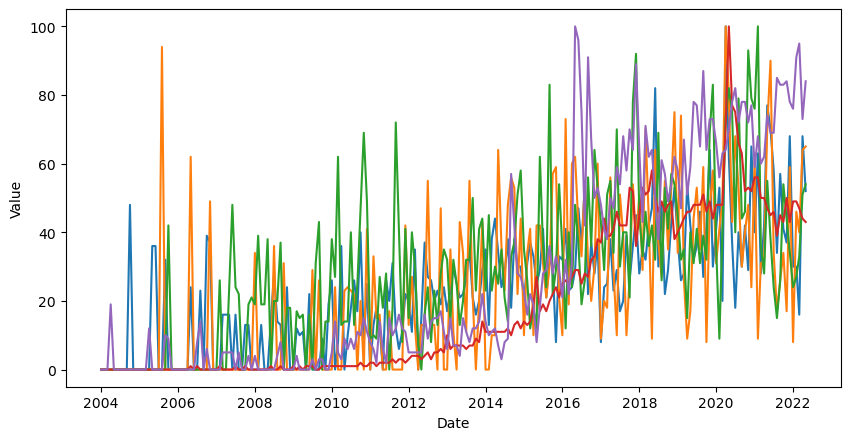

In [11]:
plots.plots.plot_df(ecommerce_keyword_ts[ecommerce_keyword_ts.columns[10:15]], width = 10)

###  Trend removal

#### Extracting and removing trend

In [12]:
import datapreprocessing as dpp

In [13]:
normalized_ecommerce_keyword = dpp.processing.normalize(ecommerce_keyword_ts)
detrend_ecommerce_keyword = (dpp.processing.detrend(normalized_ecommerce_keyword))
stationaryTest.check_stationaritytest.check_stationarity(detrend_ecommerce_keyword)

Series DoorDash is trend stationary, trend needs to be removed
All other series are stationary


In [14]:
predictor = dpp.processing.make_predictors_df(detrend_ecommerce_keyword)
response = dpp.processing.make_predictors_df(retailEcommercesales_ts[['Growth_rate']])

In [15]:
detrend_ecommerce_keyword.head(3)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.215939,0.0,...,0.0,0.0,-0.447656,0.256084,2.493022,0.0,-4.507752,0.0,0.0,0.000000
2004-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.205977,0.0,...,0.0,0.0,-0.373047,-1.344440,0.541961,0.0,5.634690,0.0,0.0,5.857352
2004-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.401992,0.0,...,0.0,0.0,0.000000,1.472482,-1.842668,0.0,-5.634690,0.0,0.0,-3.514411


### Split dataset into train, validation, test dataset

In [16]:
import datapreprocessing

In [17]:
train_df, test_df, extra_df = dpp.processing.ts_train_test_split(retailEcommercesales_ts[['Growth_rate']],detrend_ecommerce_keyword, 0.2)

In [18]:
def lag_plots(data):
    """plots acf and pacf plots"""
    plot_acf(data)
    plot_pacf(data)

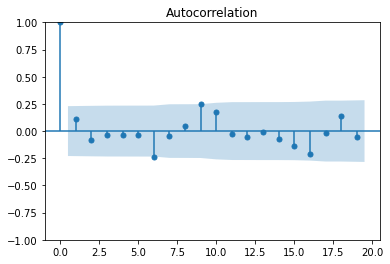

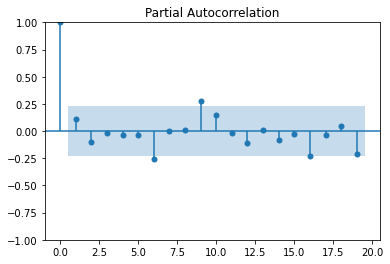

In [19]:
lag_plots(retailEcommercesales_ts[['Growth_rate']])

**Components of time series**

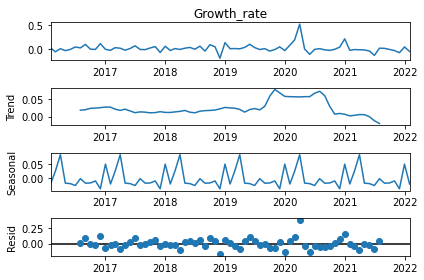

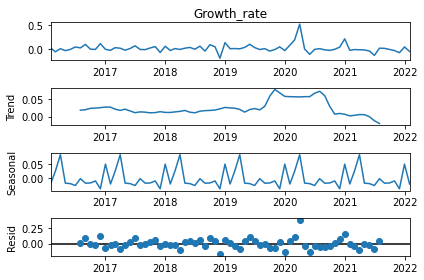

In [20]:
result=seasonal_decompose(retailEcommercesales_ts['Growth_rate'],  model='additive')
result.plot()

### Random Forest Model

In [21]:
import rfmodel
import rolling

In [22]:
def plot_feature_importance(importance, names, model_type, most_important_predictors=20):

        #Create arrays from feature importance and feature names
        feature_importance = np.array(importance)
        feature_names = np.array(names)

        #Create a DataFrame using a Dictionary
        data={'feature_names':feature_names,'feature_importance':feature_importance}
        fi_df = pd.DataFrame(data)

        #Sort the DataFrame in order decreasing feature importance
        fi_df=fi_df.sort_values(by=['feature_importance'], ascending=False)
        fi_df=fi_df[0:most_important_predictors]

        #Define size of bar plot
        plt.figure(figsize=(10,8))
        #Plot Seaborn bar chart
        sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

        #Add chart labels
        plt.title(model_type + 'FEATURE IMPORTANCE')
        plt.xlabel('FEATURE IMPORTANCE')
        plt.ylabel('FEATURE NAMES')
    

**Model fitting Random Forest**

In [23]:
# get data for random forest
rf_predictors, rf_response = dpp.lag.get_lag1_data(retailEcommercesales_ts, detrend_ecommerce_keyword, response_var='Growth_rate')

print(rf_predictors.shape)
print(rf_response.shape)

(75, 31)
(72, 1)


In [ ]:
# def ts_train_test_split(response, predictor, test_size):
#     " splits the train and test set and also returns the extra test data of predictors"
#     # train test split
#     joind_df = pd.merge(response, predictor, left_index=True, right_index=True)
#     train, test = train_test_split(joind_df, test_size=test_size, shuffle=False)
#     # extra test data
#     extra_test_data = predictor.loc[predictor.index > joind_df.index[len(joind_df.index)-1], :]
#     return train, test, extra_test_data

In [24]:
# train test split
train_rf, test_rf, extra_rf = dpp.processing.ts_train_test_split(rf_response, rf_predictors, test_size=0.2)
train_rf.shape

(57, 32)

In [25]:
# fit model
rfmodel =rfmodel.rf_modelfit.randomForest_modelfit(train_rf, dependent_var='Growth_rate',n_trees=600)

# fitted growth rate
X_rf, y_rf = train_rf.loc[:, ~train_rf.columns.isin(['Growth_rate'])], train_rf[['Growth_rate']]
fitted_growthRate_rf = rfmodel.predict(X_rf)
fitted_growthRate_rf = pd.DataFrame(fitted_growthRate_rf, columns={'Fitted EcommerceSales_GrowthRate'})
fitted_growthRate_rf.index = train_rf.index

In [26]:
# Rolling prediction of growth rate

pred_growthrate_rf = rolling.rolling.rolling_prediction_randomForest(train_rf, test_rf,extra_rf, dependent_var='Growth_rate',n_trees=600)

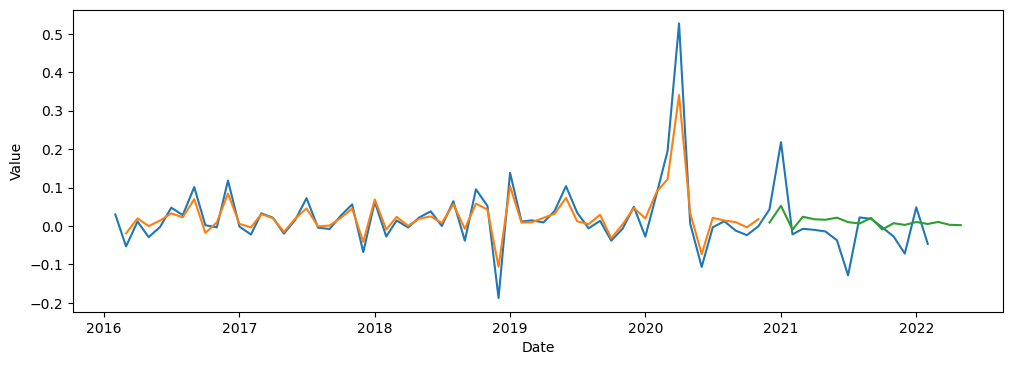

In [27]:
#fitted Ecommerce Sales

fitted_values_rf = pd.DataFrame({'EcommerceSales_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                'Fitted Value': fitted_growthRate_rf.squeeze(),
                                'Predicted Value': pred_growthrate_rf.squeeze()})
plots.plots.plot_df(fitted_values_rf, width=12, height=4)

In [28]:
import fittedval

In [ ]:
retailEcommercesales.head(2)

In [29]:
retailEcommercesales=retailEcommercesales.set_index(['Date'])
retailEcommercesales.index = pd.to_datetime(retailEcommercesales.index)

In [ ]:
retailEcommercesales.loc[test_rf.index[1]][0]

Prediction error: 341413.9941628031


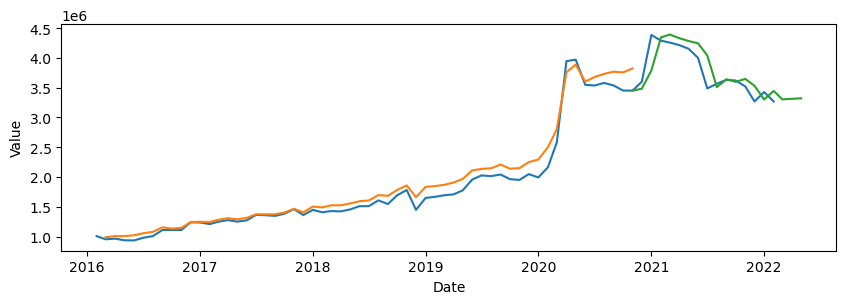

In [30]:
#n_trees=600
prediction_error, figure, actual_fitted_sales = fittedval.fit.fitted_and_predicted_sales_randomForest(rfmodel, pred_growthrate_rf, retailEcommercesales, train_rf, test_rf, extra_rf)

#### Bootstrap

In [31]:
from arch.bootstrap import optimal_block_length, CircularBlockBootstrap
from numpy.random import RandomState

In [32]:
def get_bootstrap_samples(train_data, n_sample=100, rs=None):
    """ get circular and overlapping bootstrap samples """

    #block_size = int(optimal_block_length(train_data).mean()[1])
    #print("Block size: ", block_size)
    bs = CircularBlockBootstrap(10, train_data, random_state=rs)
    bs_data_lst = list()

    # create list of bootstrap samples
    for data in bs.bootstrap(n_sample):
        data[0][0].index = train_data.index
        bs_data_lst.append(data[0][0])
    return bs_data_lst


In [ ]:
# function to plot prediction band for growth rate and also returns prediction band data
def growth_rate_plot_and_data_bs_ecommerce(predicted_growth_df=None,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= None, 
                              gdpts = None, 
                              train = None,
                              pred_gdpGrowth = None,fitted_growthrate=None):

    pred_growth_rate_data = pd.DataFrame(columns=['Predicted E-commerce Growth Rate',
                                                  'Prediction interval (2.5%)',
                                                  'Prediction interval (97.5%)',
                                                  'Mean (Prediction interval)'])
    # calcualte quantiles
    quantiles = predicted_growth_df.quantile(q=[0.025, 0.975], axis=1, interpolation='linear')
    growth_quantiles = np.transpose(quantiles)

    pred_growth_rate_data['Predicted E-commerce Growth Rate'] = pred_gdpGrowth
    pred_growth_rate_data['Prediction interval (2.5%)'] = growth_quantiles[lower_q]
    pred_growth_rate_data['Prediction interval (97.5%)'] = growth_quantiles[upper_q]
    pred_growth_rate_data['Mean (Prediction interval)'] = predicted_growth_df.mean(axis=1)

    # organise data for plot
    pred_gdpGrowth_for_plot = pd.concat([train['Growth_rate'].tail(1), pred_gdpGrowth])
    fitted_values = pd.DataFrame({'Ecommerce_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                  'Fitted Value': fitted_growthrate.squeeze(),
                                  'Predicted Value': pred_gdpGrowth_for_plot.squeeze()})

    # plot
    fitted_values.index = pd.to_datetime(fitted_values.index)
    fig = plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(fitted_values, marker='o', markersize=4)
    plt.plot(predicted_growth_df.mean(axis=1), color='green', linestyle='--')
    plt.fill_between(growth_quantiles.index, growth_quantiles[lower_q], growth_quantiles[upper_q], alpha = 0.2, color = 'green')
    plt.gca().set(title="", xlabel="", ylabel="")
    plt.close()
    return fig, pred_growth_rate_data

In [ ]:
# create bootstrap samples
bs_samples = get_bootstrap_samples(train_rf, n_sample=10, rs=RandomState(1234))

# get predicted growth rate uisng bootstrap samples
predicted_growth_df = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_temp = rolling_prediction_randomForest(df, test_rf, extra_rf, dependent_var='Growth_rate',n_trees=100)
    predicted_growth_df.iloc[:, i] = predicted_growth_temp[0]

In [ ]:
predicted_growth_df

In [ ]:
fig, pred_growth_rate_data = growth_rate_plot_and_data_bs(predicted_growth_df=predicted_growth_df,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= rfmodel, 
                              gdpts = retailEcommercesales_ts, 
                              train = train_rf,
                              pred_gdpGrowth = pred_growthrate_rf,fitted_growthrate=fitted_growthRate_rf)

fig

In [ ]:
pred_growth_rate_data.tail()

In [ ]:
# get predicted gdp value for bootstrap samples

predicted_e_df_bs = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_rate_temp = predicted_growth_df[[i]].rename(columns={i: 0})
    _, _, e_data = fitted_and_predicted_sales_randomForest(rfmodel, predicted_growth_rate_temp, retailEcommercesales, train_rf, test_rf, extra_rf)
    predicted_e_df_bs.iloc[:, i] = e_data['Predicted Retail'].dropna()

In [ ]:
e_data.head()

In [ ]:
def ecommerce_plot_and_data_bs(modelfit, pred_EcommerceGrowth, retailEcommercesales, train, test, extra_test, predicted_e_df_bs, lower_q = 0.025, upper_q = 0.975):
    # fitted gdp value for training set
    base_sales = retailEcommercesales['Ecommerce_sales'][1]
    
    # calculate fitted retail sales
    X_xgboost = train.loc[:, ~train.columns.isin(['Growth_rate'])]
    fitted_values = modelfit.predict(X_xgboost)  # fitted growth rate
    fitted_values = pd.DataFrame(fitted_values, columns={'Fitted GrowthRate'})
    fitted_values.index = train.index
    
    fitted_sales = [0]*(len(fitted_values)+1)
    fitted_sales[0] = base_sales
    for i, value in enumerate(fitted_values['Fitted GrowthRate']):
        fitted_sales[i+1] = fitted_sales[i]*(1 + value)
    fitted_sales_df = pd.DataFrame(fitted_sales[1:])
    fitted_sales_df.index = train.index

    #Test
    base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
    predicted_sales = [0]*pred_EcommerceGrowth.shape[0]
    actual_sales = base_sales_test
    if not test.empty:
        for i in range(0, test.shape[0]):
            value = pred_EcommerceGrowth[0][i]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = retailEcommercesales.loc[test.index[i]][0]
        predicted_sales_df = pd.DataFrame(predicted_sales)
        predicted_sales_df.index = pred_EcommerceGrowth.index
        predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])

        # prediction error calculation
        org = retailEcommercesales[retailEcommercesales.index >= pred_EcommerceGrowth.index[0]]
        error = 0
        for i in range(0, test.shape[0]):
            error = error + (org['Ecommerce_sales'][i]-predicted_sales_df[0][i])**2
        pred_error = np.sqrt(error/predicted_sales_df.shape[0])
        print(f"Prediction error: {pred_error}")

    # predicted sales trade value for extra test set when test set is not empty
    if not extra_test.empty and not test.empty:
        base_sales_test = retailEcommercesales[retailEcommercesales.index == test.index[-1]]['Ecommerce_sales'][0]
        actual_sales = base_sales_test
        for i in range(0, extra_test.shape[0]):
            value = pred_EcommerceGrowth.iloc[test.shape[0]+i][0]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = predicted_sales[i]
            predicted_sales_df.iloc[test.shape[0]+i+1][0] = predicted_sales[i]

    # predicted sales trade value for extra test set when test set is empty
    if not extra_test.empty and test.empty:
        base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
        actual_sales = base_sales_test
        for i in range(0, extra_test.shape[0]):
            value = pred_EcommerceGrowth.iloc[i][0]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = predicted_sales[i]
        predicted_sales_df = pd.DataFrame(predicted_sales)
        predicted_sales_df.index = pred_EcommerceGrowth.index
        predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])
        pred_error = None

    pred_e_data = pd.DataFrame(columns=['Predicted Ecommerce Value',
                                                  'Prediction interval (2.5%)',
                                                  'Prediction interval (97.5%)',
                                                  'Mean (Prediction interval)'])
    # calcualte quantiles
    quantiles = predicted_e_df_bs.quantile(q=[lower_q, upper_q], axis=1, interpolation='linear')
    value_quantiles = np.transpose(quantiles)

    pred_e_data['Predicted Ecommerce Value'] = predicted_sales_df[0][1:]
    pred_e_data['Prediction interval (2.5%)'] = value_quantiles[lower_q]
    pred_e_data['Prediction interval (97.5%)'] = value_quantiles[upper_q]
    pred_e_data['Mean (Prediction interval)'] = predicted_e_df_bs.mean(axis=1)

    Actual_Ecommerce = retailEcommercesales['Ecommerce_sales'][1:]
    fittedandActual_sales = pd.DataFrame({'Actual Ecommerce': Actual_Ecommerce,
                                        'Fitted Ecommerce': fitted_sales_df.squeeze(),
                                        'Predicted Ecommerce': predicted_sales_df.squeeze()
                                       })

    # plot
    fittedandActual_sales.index = pd.to_datetime(fittedandActual_sales.index)
    fig = plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(fittedandActual_sales, marker='o', markersize=4)
    plt.plot(predicted_e_df_bs.mean(axis=1), color='green', linestyle='--')
    plt.fill_between(value_quantiles.index, value_quantiles[lower_q], value_quantiles[upper_q], alpha = 0.2, color = 'green')
    plt.gca().set(title="", xlabel="", ylabel="")
    plt.close()
    return fig, pred_e_data

In [ ]:
fig, pred_e_data = ecommerce_plot_and_data_bs(rfmodel, pred_growthrate_rf, retailEcommercesales, train_rf, test_rf, extra_rf, predicted_e_df_bs, 
                                          lower_q = 0.025, upper_q = 0.975)
fig